<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/%E3%83%9E%E3%83%8F%E3%83%A9%E3%83%8E%E3%83%93%E3%82%B9%E8%B7%9D%E9%9B%A2%E3%81%A8%E3%82%AB%E3%82%A4%E4%BA%8C%E4%B9%97%E5%88%86%E5%B8%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# 2次元散布図とマハラノビス距離による異常検知
# 目的：
# - 強い相関を持つ2次元の「正常」データに対して、
#   ユークリッド距離だと偏った誤検知が起きやすいことを可視化
# - マハラノビス距離だと共分散を考慮するため、より適切に検知できることを確認
#
# 使い方：このセルをそのまま実行すれば、指標出力と図が順に表示されます。

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2


In [19]:
# ===== 1) データ生成 =====
# 強い正の相関を持つ2次元ガウス（楕円分布）の「正常」データ
rng = np.random.default_rng(42)
mean = np.array([0.0, 0.0])
cov = np.array([[9.0, 8.0],
                [8.0, 9.0]])  # 相関が強い

n_train = 800            # 閾値設計用の正常データ
n_test_normal = 400      # 評価用の正常データ
train_normal = rng.multivariate_normal(mean, cov, size=n_train)
test_normal  = rng.multivariate_normal(mean, cov, size=n_test_normal)

# 異常点（相関方向から外れた位置や、遠方）を少数混入
anomalies = np.array([
    [  8.0, -8.0],
    [ -7.0,  7.5],
    [ 15.0,  0.0],
    [  0.0, 15.0],
    [ -13.0, -2.0],
    [ -2.0, -13.0],
])

# 評価用データとラベル（0=正常, 1=異常）
X_test = np.vstack([test_normal, anomalies])
y_test = np.array([0]*len(test_normal) + [1]*len(anomalies))

In [20]:
# ===== 2) ユークリッド距離による異常検知 =====
# 単純に「平均からの距離」が遠ければ異常とみなす方式
mean_train = train_normal.mean(axis=0)

def euclidean_dist2(x, mu):
    # ユークリッド距離の2乗（平方根を取らないで計算コストと単調性を維持）
    d = x - mu
    return np.sum(d*d, axis=1)

dist2_e_train = euclidean_dist2(train_normal, mean_train)
dist2_e_test  = euclidean_dist2(X_test,      mean_train)

# 学習データの上位1%点を閾値に（経験的しきい値、相関を無視しているため偏りが出やすい）
th_e = np.quantile(dist2_e_train, 0.99)
pred_e = (dist2_e_test > th_e).astype(int)


In [21]:
# ===== 3) マハラノビス距離による異常検知 =====
# 共分散行列を推定し、その逆行列でスケール・相関を補正して距離を測る
cov_train = np.cov(train_normal, rowvar=False)
cov_inv = np.linalg.inv(cov_train)

def mahalanobis_dist2(x, mu, cov_inv):
    # マハラノビス距離の2乗： (x - mu)^T Σ^{-1} (x - mu)
    d = x - mu
    return np.einsum('ij,jk,ik->i', d, cov_inv, d)

dist2_m_train = mahalanobis_dist2(train_normal, mean_train, cov_inv)
dist2_m_test  = mahalanobis_dist2(X_test,      mean_train, cov_inv)

# 次元=2 のカイ二乗分布に従う前提で 99%点を理論閾値に
th_m = chi2.ppf(0.99, df=2)
pred_m = (dist2_m_test > th_m).astype(int)

In [22]:
# ===== 4) 簡易評価（混同行列要約） =====
def confusion(y_true, y_pred):
    tp = int(((y_true==1) & (y_pred==1)).sum())
    tn = int(((y_true==0) & (y_pred==0)).sum())
    fp = int(((y_true==0) & (y_pred==1)).sum())
    fn = int(((y_true==1) & (y_pred==0)).sum())
    return tp, tn, fp, fn

tp_e, tn_e, fp_e, fn_e = confusion(y_test, pred_e)
tp_m, tn_m, fp_m, fn_m = confusion(y_test, pred_m)

print("=== ユークリッド距離による結果 ===")
print(f"TP(真陽性): {tp_e}, TN(真陰性): {tn_e}, FP(偽陽性): {fp_e}, FN(偽陰性): {fn_e}")
print("※相関を無視するため、長軸方向の正常点が誤検知されやすい（FP↑）\n")

print("=== マハラノビス距離による結果 ===")
print(f"TP(真陽性): {tp_m}, TN(真陰性): {tn_m}, FP(偽陽性): {fp_m}, FN(偽陰性): {fn_m}")
print("※共分散を考慮するため、楕円形の等確率境界で適切に判定できる\n")


=== ユークリッド距離による結果 ===
TP(真陽性): 5, TN(真陰性): 393, FP(偽陽性): 7, FN(偽陰性): 1
※相関を無視するため、長軸方向の正常点が誤検知されやすい（FP↑）

=== マハラノビス距離による結果 ===
TP(真陽性): 6, TN(真陰性): 395, FP(偽陽性): 5, FN(偽陰性): 0
※共分散を考慮するため、楕円形の等確率境界で適切に判定できる



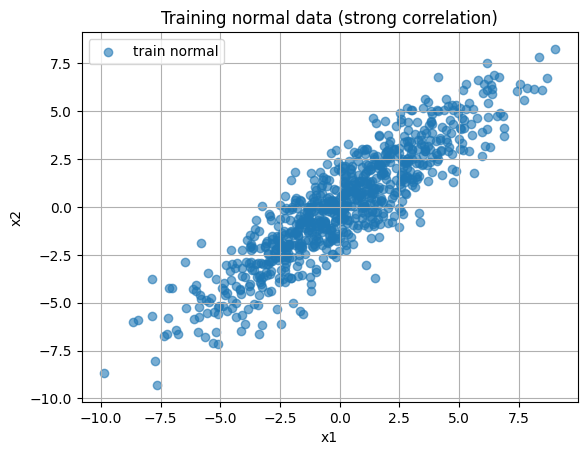

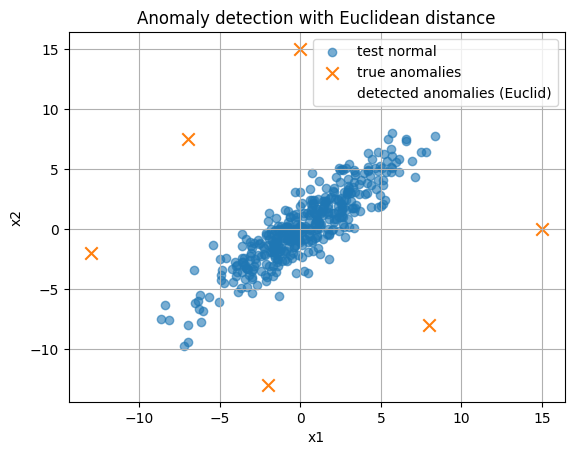

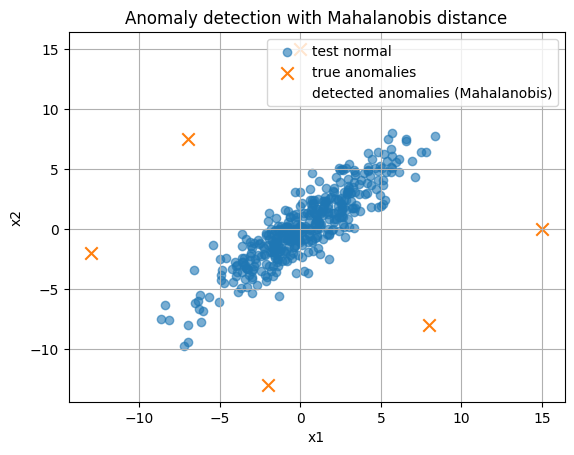

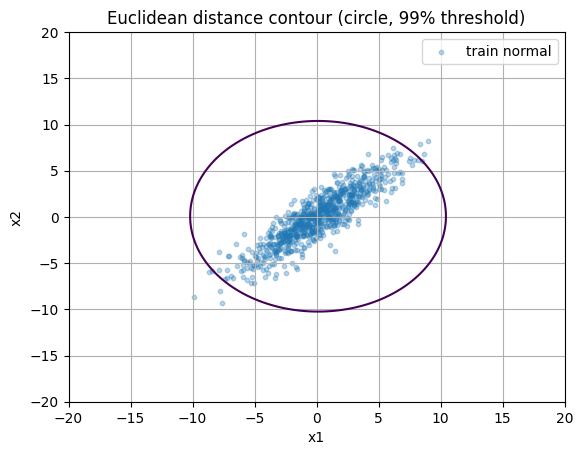

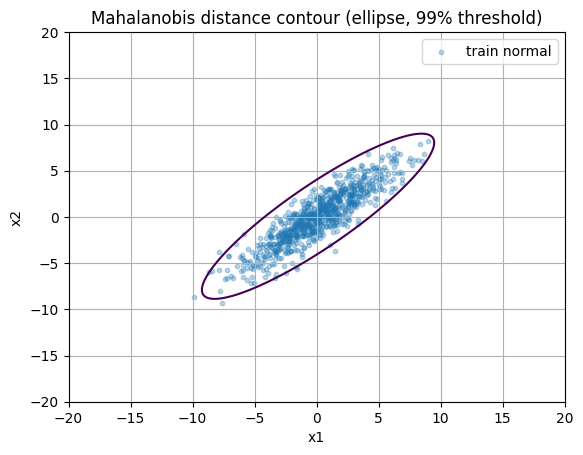

In [24]:
# 可視化

# 5-1) Training data scatter plot
plt.figure()
plt.title("Training normal data (strong correlation)")
plt.scatter(train_normal[:,0], train_normal[:,1], alpha=0.6, label="train normal")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()

# 5-2) Euclidean detection result
plt.figure()
plt.title("Anomaly detection with Euclidean distance")
plt.scatter(X_test[y_test==0,0], X_test[y_test==0,1], alpha=0.6, label="test normal")
plt.scatter(X_test[y_test==1,0], X_test[y_test==1,1], marker="x", s=80, label="true anomalies")
idx_detected_e = np.where(pred_e==1)[0]
plt.scatter(X_test[idx_detected_e,0], X_test[idx_detected_e,1],
            facecolors='none', edgecolors=None, s=200, label="detected anomalies (Euclid)")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()

# 5-3) Mahalanobis detection result
plt.figure()
plt.title("Anomaly detection with Mahalanobis distance")
plt.scatter(X_test[y_test==0,0], X_test[y_test==0,1], alpha=0.6, label="test normal")
plt.scatter(X_test[y_test==1,0], X_test[y_test==1,1], marker="x", s=80, label="true anomalies")
idx_detected_m = np.where(pred_m==1)[0]
plt.scatter(X_test[idx_detected_m,0], X_test[idx_detected_m,1],
            facecolors='none', edgecolors=None, s=200, label="detected anomalies (Mahalanobis)")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()

# 5-4) Euclidean contour (circle)
xx, yy = np.meshgrid(np.linspace(-20, 20, 200), np.linspace(-20, 20, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
d2e_grid = euclidean_dist2(grid, mean_train).reshape(xx.shape)

plt.figure()
plt.title("Euclidean distance contour (circle, 99% threshold)")
plt.contour(xx, yy, d2e_grid, levels=[th_e])
plt.scatter(train_normal[:,0], train_normal[:,1], alpha=0.3, s=10, label="train normal")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()

# 5-5) Mahalanobis contour (ellipse)
d2m_grid = mahalanobis_dist2(grid, mean_train, cov_inv).reshape(xx.shape)

plt.figure()
plt.title("Mahalanobis distance contour (ellipse, 99% threshold)")
plt.contour(xx, yy, d2m_grid, levels=[th_m])
plt.scatter(train_normal[:,0], train_normal[:,1], alpha=0.3, s=10, label="train normal")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()